## Orientation feature tracking hybrid
We do limbus detection using Hough transform, where we obtain translation and scale. We manually pick the zeroth degree in initial frame. Then features are detected and rotation is estimated relative to the first frame.

### 1. Imports

In [1]:
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
from helpers.limbus_detection import detect_circle
from helpers.video_manipulation import extract_consecutive

%load_ext autoreload
%autoreload 2

### 2. Limbus tracking

In [2]:
WINDOW_SIZE = 15

cap = cv2.VideoCapture('data/artificial/rhexis_input_long_rotating2_lofi.mp4')
circles_window = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # limbus circle detection
    cur_circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )
    circles_window.append(cur_circle)
    if len(circles_window) > WINDOW_SIZE:
        circles_window = circles_window[1:WINDOW_SIZE+1]
    
    total_circles = 0
    best_circle = np.zeros(3)
    for circle in circles_window:
        if circle is None:
            continue
            
        total_circles += 1
        best_circle += circle
        
    if total_circles != 0:
        best_circle /= total_circles
        cv2.circle(base, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)

    cv2.imshow('result', base)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


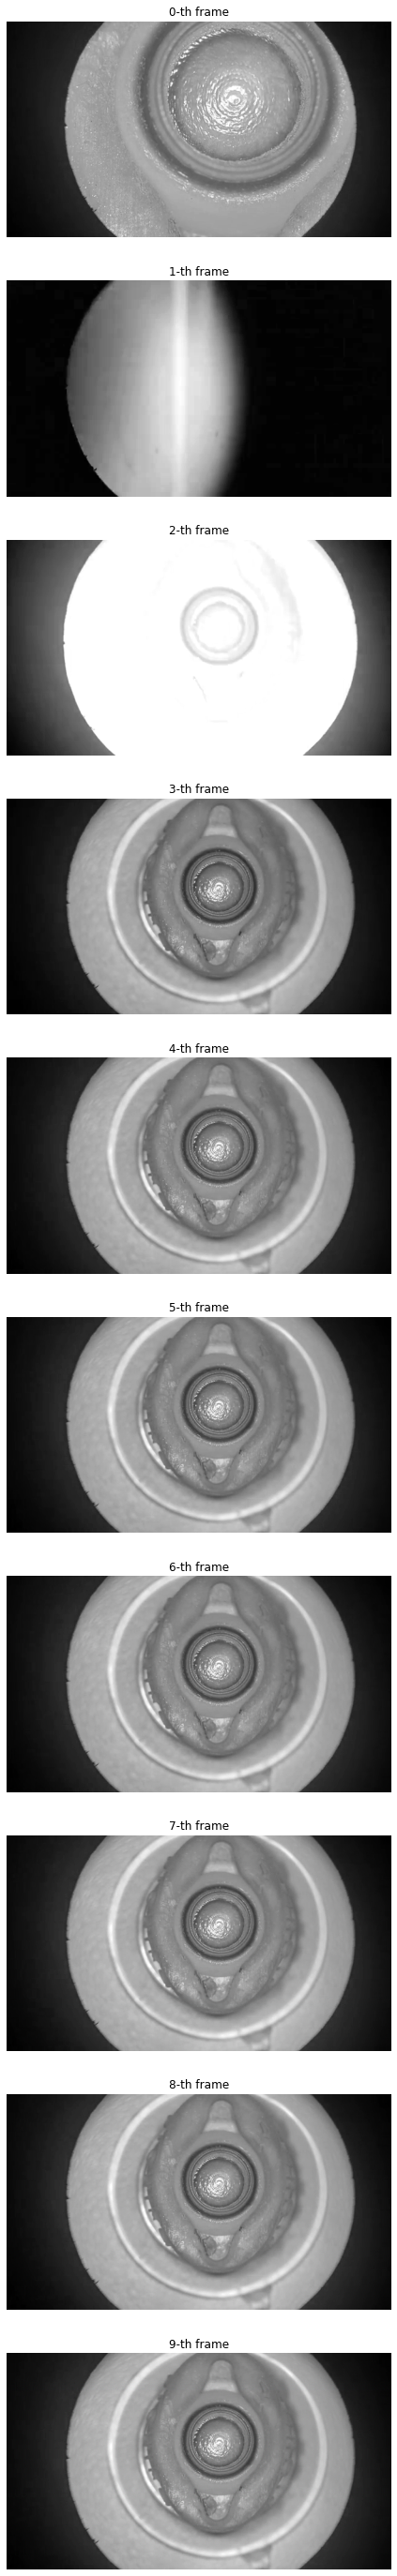

In [3]:
video_path = 'data/artificial/rhexis_input_long_rotating2_lofi.mp4'

frame_start = 73*30
frame_count = 8*30
representatives = 10
frames_full = extract_consecutive(
    video_path, frame_start, frame_start+frame_count, mode='hsv')
frames = []
for i in range(representatives):
    frames.append(frames_full[int(i * (len(frames_full) / representatives))])

_, plots = plt.subplots(len(frames), 1, figsize=(15, 5*len(frames)))
for i, frame in enumerate(frames):
    plots[i].set_title('%s-th frame' % i)
    plots[i].imshow(frame[:, :, 2], cmap='gray')
    plots[i].axis('off')

plt.show()

In [4]:
limbus_circles = []

for frame in frames:
    circle = detect_circle(
        frame[:, :, 2],
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )

    limbus_circles.append(circle)

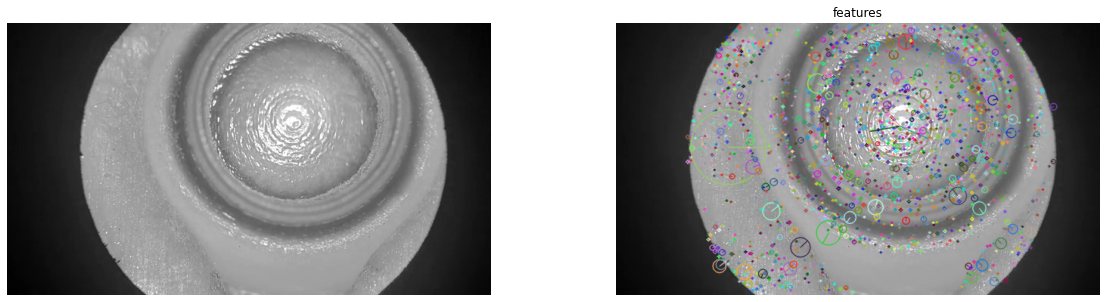

1750 keypoints detected


In [5]:
keypoint_target = frames[0][:, :, 2]

sift = cv2.SIFT_create(contrastThreshold=0.01)
sift_keypoints = sift.detect(keypoint_target, None)

keypoint_target_result = cv2.drawKeypoints(keypoint_target, sift_keypoints, None,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('')
plot1.imshow(keypoint_target, cmap='gray')
plot1.axis('off')

plot2.set_title('features')
plot2.imshow(cv2.cvtColor(keypoint_target_result, cv2.COLOR_BGR2RGB))
plot2.axis('off')

plt.show()

print('%s keypoints detected' % len(sift_keypoints))

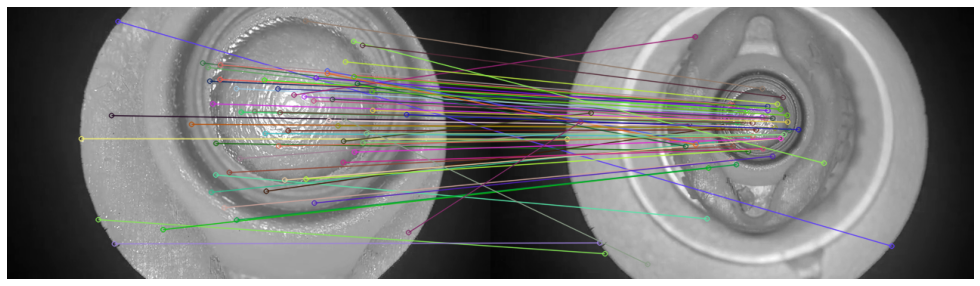

59 good matches found


In [6]:
from_index = 0
to_index = -1

keypoint_target_from = frames[from_index][:, :, 2]
limbus_circle_from = limbus_circles[from_index]
keypoint_target_to = frames[to_index][:, :, 2]
limbus_circle_to = limbus_circles[to_index]

assert (limbus_circle_from is not None) and (limbus_circle_to is not None)

# SIFT detector initialization
sift = cv2.SIFT_create(contrastThreshold=0.01)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(keypoint_target_from, None)
kp2, des2 = sift.detectAndCompute(keypoint_target_to, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# ratio test
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

matches_vis = cv2.drawMatchesKnn(keypoint_target_from, kp1, keypoint_target_to, kp2, good, None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, plot = plt.subplots(1, 1, figsize=(20, 5))
plot.imshow(matches_vis)
plot.axis('off')

plt.show()

print('%s good matches found' % len(good))

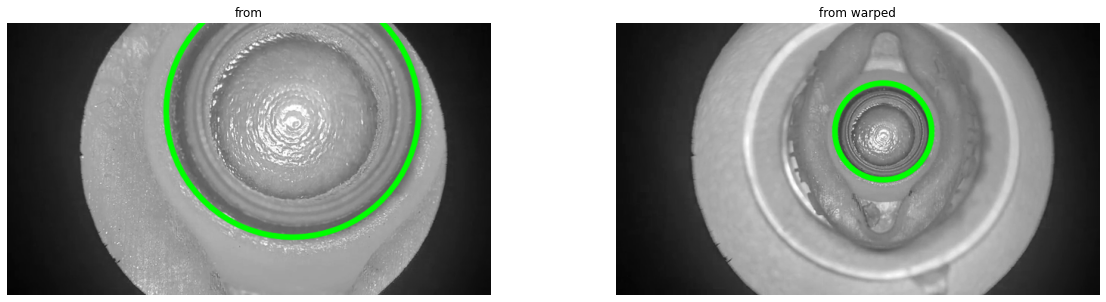

In [7]:
limbus_detection_from = cv2.cvtColor(keypoint_target_from, cv2.COLOR_GRAY2RGB)
limbus_detection_to = cv2.cvtColor(keypoint_target_to, cv2.COLOR_GRAY2RGB)

cv2.circle(limbus_detection_from, (round(limbus_circle_from[0]), round(limbus_circle_from[1])), round(
            limbus_circle_from[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)
cv2.circle(limbus_detection_to, (round(limbus_circle_to[0]), round(limbus_circle_to[1])), round(
            limbus_circle_to[2]), (0, 255, 0), thickness=5, lineType=cv2.LINE_AA)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('from')
plot1.imshow(limbus_detection_from)
plot1.axis('off')

plot2.set_title('from warped')
plot2.imshow(limbus_detection_to)
plot2.axis('off')

plt.show()

In [8]:
def get_transform_limbus(limbus_circle_from, limbus_circle_to):
    scale =  limbus_circle_to[2] / limbus_circle_from[2]
    translation = (limbus_circle_to[:2] - scale * limbus_circle_from[:2])
    return np.array([
        [scale, 0    , translation[0]],
        [0    , scale, translation[1]]
    ])

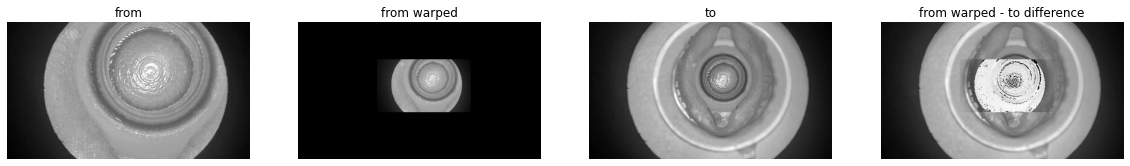

In [9]:
transform = get_transform_limbus(limbus_circle_from, limbus_circle_to)

keypoint_target_from_warped = cv2.warpAffine(keypoint_target_from, transform,
                                             (keypoint_target_to.shape[1], keypoint_target_to.shape[0]))

diff = cv2.normalize(keypoint_target_to - keypoint_target_from_warped, None,
                     alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

fig, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4, figsize=(20, 5))
plot1.set_title('from')
plot1.imshow(keypoint_target_from, cmap='gray')
plot1.axis('off')

plot2.set_title('from warped')
plot2.imshow(keypoint_target_from_warped, cmap='gray')
plot2.axis('off')

plot3.set_title('to')
plot3.imshow(keypoint_target_to, cmap='gray')
plot3.axis('off')

plot4.set_title('from warped - to difference')
plot4.imshow(diff, cmap='gray')
plot4.axis('off')

plt.show()

In [10]:
def transform_keypoints(keypoints, transform):
    points = [
        [k.pt[0], k.pt[1]]
        for k in keypoints
    ]
    points = np.array(points).T
    points = np.concatenate((points, np.ones((1, len(keypoints)))))
    points = transform @ points
    
    keypoints_transformed = tuple(
        cv2.KeyPoint(x = points[0, i] , y = points[1, i], 
            size = k.size, angle = k.angle, 
            response = k.response, octave = k.octave, 
            class_id = k.class_id)
        for i, k in enumerate(keypoints)
    )
    
    return keypoints_transformed
    

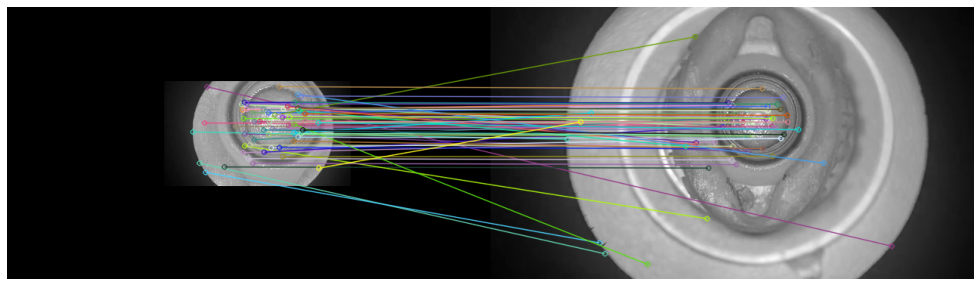

59 good matches found


In [11]:
kp1_transformed = transform_keypoints(kp1, transform)

keypoint_target_from_warped_copy = keypoint_target_from_warped.copy()

matches_vis_transformed = cv2.drawMatchesKnn(
    keypoint_target_from_warped_copy, kp1_transformed, keypoint_target_to, kp2, good, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
fig, plot = plt.subplots(1, 1, figsize=(20, 5))
plot.imshow(matches_vis_transformed)
plot.axis('off')

plt.show()

print('%s good matches found' % len(good))

In [12]:
def get_transform_info(transform, verbose=False):
    a = transform[0, 0]
    b = transform[1, 0]
    alpha = np.arctan2(b, a)
    s = a / np.cos(alpha)
    
    scale = s
    translation = transform[:, 2]
    rotation = 180*alpha/np.pi
    
    if verbose:
        print(f'translation (px): {translation}, rotation angle (deg): {rotation}, scale: {scale}')
    
    return scale, translation, rotation

In [13]:
def estimate_transform_from_matches(keypoints_from, keypoints_to, matches):
    points_from = np.array([keypoints_from[m[0].queryIdx].pt for m in matches])
    points_to = np.array([keypoints_to[m[0].trainIdx].pt for m in matches])

    transform, inliers = cv2.estimateAffinePartial2D(
        np.array([keypoints_from[m[0].queryIdx].pt for m in matches]),
        np.array([keypoints_to[m[0].trainIdx].pt for m in matches])
    )
    
    return transform, inliers

In [14]:
transform, inliers = estimate_transform_from_matches(kp1_transformed, kp2, good)
get_transform_info(transform, verbose=True)
print(transform)

translation (px): [3.29589298 3.25593101], rotation angle (deg): 0.0033319720492596613, scale: 0.9893849628299418
[[ 9.89384961e-01 -5.75365772e-05  3.29589298e+00]
 [ 5.75365772e-05  9.89384961e-01  3.25593101e+00]]


In [15]:
transform.shape

(2, 3)

In [16]:
np.concatenate((transform, np.expand_dims(np.array([0, 0, 1]), axis=0)))

array([[ 9.89384961e-01, -5.75365772e-05,  3.29589298e+00],
       [ 5.75365772e-05,  9.89384961e-01,  3.25593101e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [17]:
def estimate_transformation_hybrid(keypoints_from, descriptors_from, limbus_circle_from,
         keypoints_to, descriptors_to, limbus_circle_to):
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_from, descriptors_to, k=2)

    # ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
            
    if not good:
        return None
    
    transform_no_rotation = get_transform_limbus(limbus_circle_from, limbus_circle_to)
    keypoints_from_transformed = transform_keypoints(keypoints_from, transform_no_rotation)
    transform_rotation, _ = estimate_transform_from_matches(keypoints_from_transformed, keypoints_to, good)
    
    last_row = np.expand_dims(np.array([0, 0, 1]), axis=0)
    transform_no_rotation = np.concatenate((transform_no_rotation, last_row.copy()))
    transform_rotation = np.concatenate((transform_rotation, last_row.copy()))
    transform = transform_rotation @ transform_no_rotation
    
    return transform[:2,:]
    

In [18]:
def estimate_rotation(keypoints_from, descriptors_from, limbus_circle_from,
         keypoints_to, descriptors_to, limbus_circle_to):

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_from, descriptors_to, k=2)

    # ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
            
    if not good:
        return None
    
    transform_no_rotation = get_transform_limbus(limbus_circle_from, limbus_circle_to)
    keypoints_from_transformed = transform_keypoints(keypoints_from, transform_no_rotation)
    transform, _ = estimate_transform_from_matches(keypoints_from_transformed, keypoints_to, good)
    scale, translation, rotation = get_transform_info(transform)
    
    return rotation
    

In [19]:
# def draw_axis(base_bgr, limbus_circle, rotation):
#     rad = np.pi * rotation / 180
#     cv2.line(base_bgr, )

In [22]:

cap = cv2.VideoCapture('data/artificial/rhexis_input_long_rotating2_lofi.mp4')
sift = cv2.SIFT_create(contrastThreshold=0.01)
keypoints_from = None
descriptors_from = None
limbus_circle_from = None
from_value = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    vis = None
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # limbus circle detection
    best_circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=1.0,
        circle_width_to_radius_ratio=0.1,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=240,
        gaussian_blur_sigma=3.0
    )
    
    if best_circle is not None:
        if keypoints_from is None:
            keypoints_from, descriptors_from = sift.detectAndCompute(base_value, None)
            limbus_circle_from = best_circle
            from_value = base_value
        else:
            keypoints_to, descriptors_to = sift.detectAndCompute(base_value, None)
            limbus_circle_to = best_circle
            to_value = base_value
#             rotation =  estimate_rotation(keypoints_from, descriptors_from, limbus_circle_from, 
#                                           keypoints_to, descriptors_to, limbus_circle_to)
            transform = estimate_transformation_hybrid(keypoints_from, descriptors_from, limbus_circle_from, 
                                          keypoints_to, descriptors_to, limbus_circle_to)
    
            from_value_transformed = cv2.warpAffine(from_value, transform, (to_value.shape[1], to_value.shape[0]))
            diff = cv2.normalize(to_value - from_value_transformed, None,
                                 alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
            
            cv2.circle(base, 
                       (round(best_circle[0]), round(best_circle[1])), 
                       round(best_circle[2]), (0, 255, 0), thickness=3, 
                       lineType=cv2.LINE_AA)

            vis = cv2.vconcat((
                base, 
                cv2.cvtColor(from_value_transformed, cv2.COLOR_GRAY2BGR),
                cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)))

    if vis is not None:
        cv2.imshow('result', vis)
    else:
        cv2.imshow('result', base)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

